## Import libraries

In [ ]:
import os
import json
import transformers
import datasets
import accelerate
import peft
import torch
import torchvision
import bitsandbytes

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

## Evaluating SmolVLM

### Load Model

In [3]:
import torch
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model, PeftModel
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration

#for visible devices to be only 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE=0
USE_LORA = False
USE_QLORA = True
SMOL = True

model_id = "HuggingFaceTB/SmolVLM-Base" if SMOL else "HuggingFaceTB/SmolVLM-500M-Instruct" #"HuggingFaceM4/Idefics3-8B-Llama3"
processor = AutoProcessor.from_pretrained(model_id)

if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    lora_config.inference_mode = False
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )
    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config if USE_QLORA else None,
        _attn_implementation="eager", # "flash_attention_2"
        device_map="cuda:0"
    )
    
    model.add_adapter(lora_config)
    model.enable_adapters()
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    print(model.get_nb_trainable_parameters())
else:
    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        _attn_implementation= "eager", #"flash_attention_2",
    ).to(DEVICE)

    # if you'd like to only fine-tune LLM
    for param in model.model.vision_model.parameters():
        param.requires_grad = False

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


(10536960, 2256809840)


### Load data

In [4]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="vlm_conversation_dataset_modified.json")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 300
    })
})


In [5]:
#split the dataset
dataset = load_dataset("json", data_files="vlm_conversation_dataset_modified.json")

split_ds = dataset["train"].train_test_split(test_size=0.2, seed=42)  # 80% train, 20% validation
validation_test_split = split_ds["test"].train_test_split(test_size=0.5, seed=42)

train = split_ds["train"]
val = validation_test_split["train"]
test = validation_test_split["test"]
print(f"Train size: {len(train)}, Validation size: {len(val)}, Test size: {len(test)}")

Train size: 240, Validation size: 30, Test size: 30


In [6]:
train

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 240
})

### Results of fine tuned SmolVLM Model

In [ ]:
from transformers import AutoModelForVision2Seq

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        return_dict=True,
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
        use_cache=True,
        device_map="cuda:0"
    )
    
processor = AutoProcessor.from_pretrained(model_id)
processor.tokenizer.padding_side = "right"

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [7]:
print(f"Before adapter parameters: {model.num_parameters()}")
model.load_adapter("./SmolVLM-Base-vqav2/checkpoint-300")
print(f"After adapter parameters: {model.num_parameters()}")

Before adapter parameters: 2246272880
After adapter parameters: 2256809840


How many people are sitting?
There are 5 people sitting in the bus.


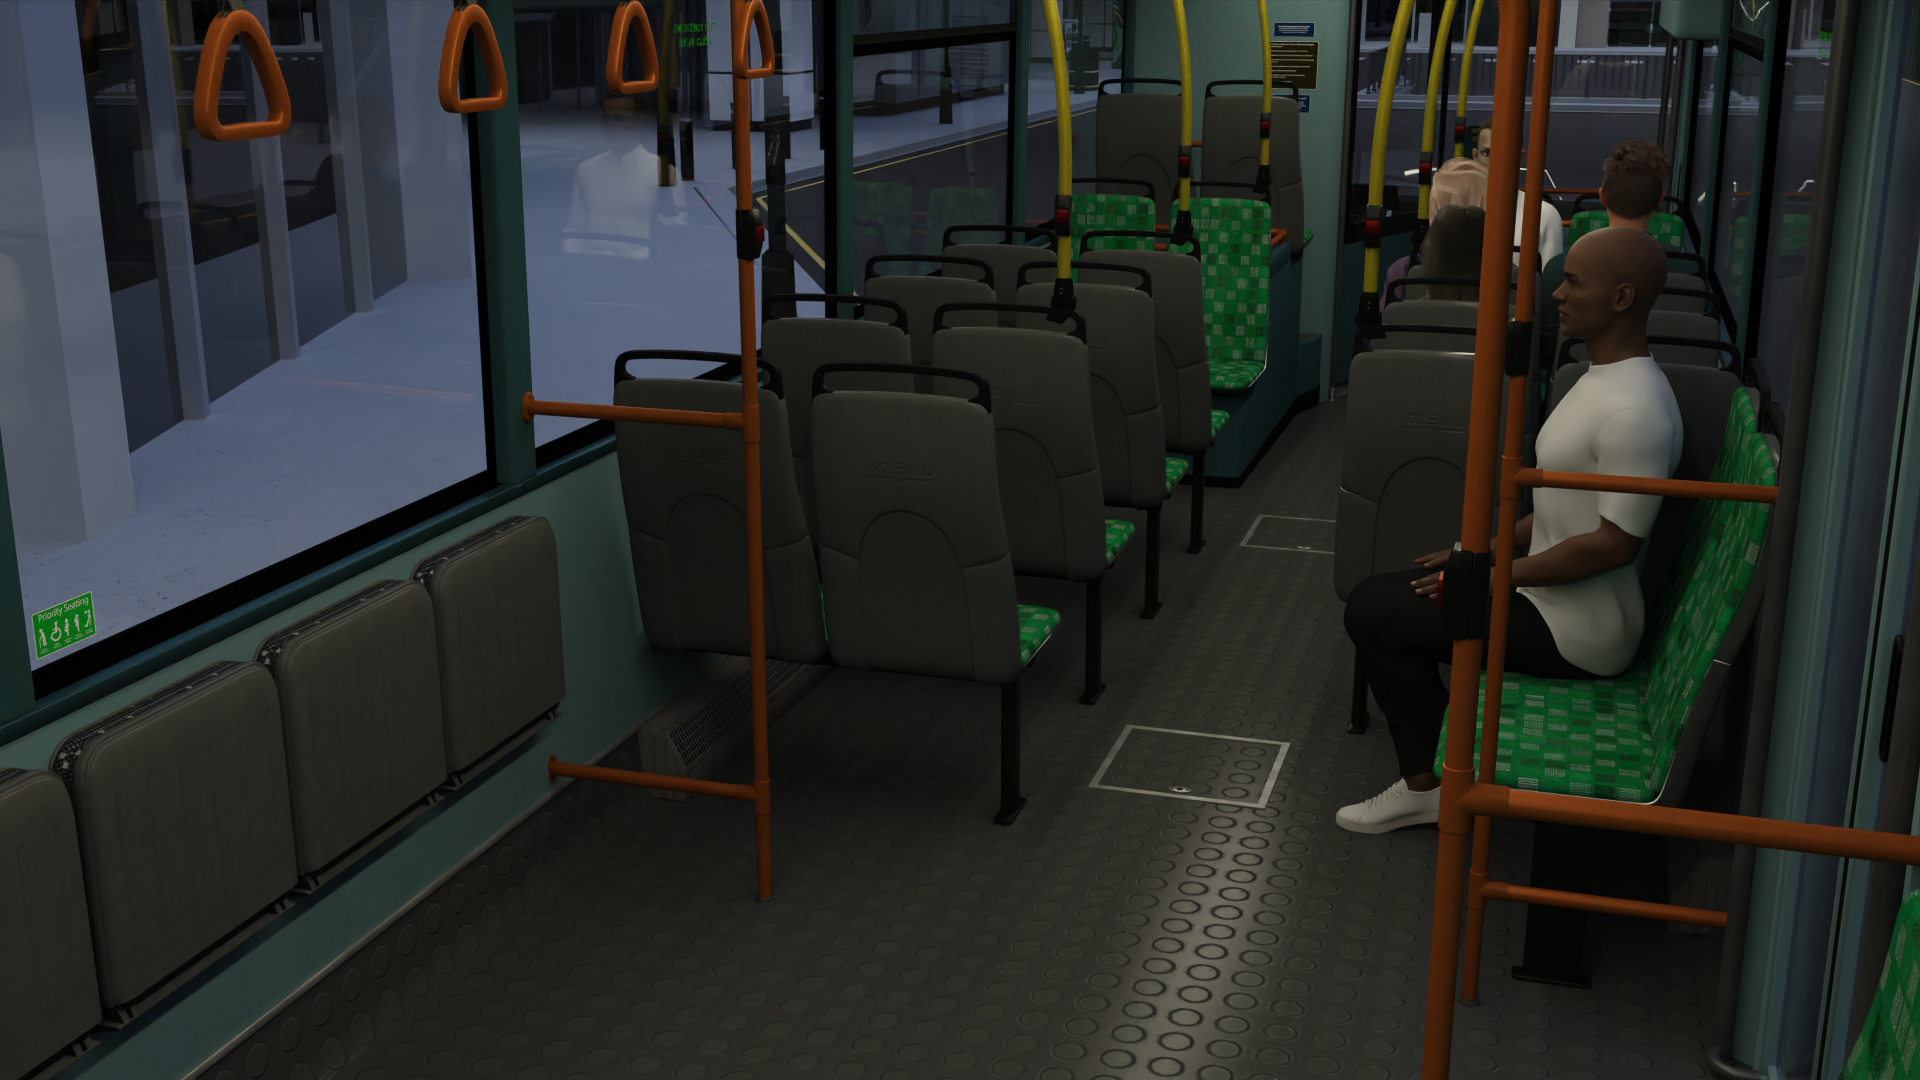

In [8]:
sample_data = test[4]
sample_question = sample_data["question"]
sample_answer = sample_data["answer"]
sample_image_path = sample_data["image"]
sample_image = Image.open(sample_image_path)

print(sample_question)
print(sample_answer)
sample_image

In [ ]:
from transformers.image_utils import load_image

def image_text_generator(sample_data):
    question = sample_data["question"]
    messages = [
            {"role": "system", "content": "You are a Vision Language Model specialized in extracting data from images.Your task is to analyze the provided image of the inside of a bus and extract the relevant information."}, 
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": question}
                ]
            },
        ]
    
    text = processor.apply_chat_template(messages, add_generation_prompt=True)

    print(f"Prompt: {text}")
    print("-"*30)

    image_inputs_path = test[0]["image"]
    image_inputs = load_image(image_inputs_path)

    inputs = processor(
        text=text,
        images = image_inputs,
        return_tensors="pt"
    )
    inputs = inputs.to("cuda:0")
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
    del inputs
    actual_answer = sample_data["answer"]
    return output_text[0], actual_answer
    

generated_text, actual_answer = image_text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Prompt: <|im_start|>System: <|endoftext|>
User:<image>How many people are sitting?<|endoftext|>
Assistant:
------------------------------
Generated Answer: System: 
User:<image>How many people are sitting?
Assistant: There are 5 people sitting in the bus.
Actual Answer: There are 5 people sitting in the bus.


### Test of finetuned SmolVLM on real image

In [ ]:
image_path = "people_sitting_in_bus.png"

def real_image_predictions(image_path, question):
    question = question
    messages = [
        {"role": "system", "content": "You are a Vision Language Model specialized in extracting data from images.Your task is to analyze the provided image of the inside of a bus and extract the relevant information."},
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": question}
                ]
            },
        ]
    
    text = processor.apply_chat_template(messages, add_generation_prompt=True)

    print(f"Prompt: {text}")
    print("-"*30)

    image_inputs = load_image(image_path)

    inputs = processor(
        text=text,
        images = image_inputs,
        return_tensors="pt"
    )
    inputs = inputs.to("cuda:0")

    generated_ids = model.generate(**inputs, max_new_tokens=128)

    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
    del inputs
    return output_text[0]
    

answer = real_image_predictions(image_path,"How many people are sitting in the bus?")
print(f"Answer: {answer}")

Prompt: <|im_start|>System: <|endoftext|>
User:<image>How many people are sitting in the bus?<|endoftext|>
Assistant:
------------------------------
Answer: System: 
User:<image>How many people are sitting in the bus?
Assistant: There are 5 people sitting in the bus.


In [12]:
image_path = "20171788-uhd_3840_2160_60fps.png"
answer = real_image_predictions(image_path, "How many people are sitting and how many people are standing in the bus?")
print(f"Answer: {answer}")

Prompt: <|im_start|>System: <|endoftext|>
User:<image>How many people are sitting and how many people are standing in the bus?<|endoftext|>
Assistant:
------------------------------
Answer: System: 
User:<image>How many people are sitting and how many people are standing in the bus?
Assistant: There are 6 people sitting and 10 people standing in the bus.
